# 1. 데이터 준비와 확인

In [1]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
! pip install gensim

! pip install --upgrade gensim==3.8.3

# 2. 데이터로더 구성

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [5]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
len(word_to_index)

10000

In [9]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

In [10]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [11]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [13]:
print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


In [14]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [15]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 48)
(30000,)
(116182, 48)
(116182,)


# LSTM

# Model

In [16]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

In [17]:
LSTM_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


# Train

In [18]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [20]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 24s 6ms/step - loss: 0.3681 - accuracy: 0.8353 - val_loss: 0.3173 - val_accuracy: 0.8643

Epoch 00001: saving model to best_model.h5
Epoch 2/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.2808 - accuracy: 0.8820 - val_loss: 0.3094 - val_accuracy: 0.8669

Epoch 00002: saving model to best_model.h5
Epoch 3/10
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2362 - accuracy: 0.9019 - val_loss: 0.3174 - val_accuracy: 0.8668

Epoch 00003: saving model to best_model.h5
Epoch 4/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.1960 - accuracy: 0.9211 - val_loss: 0.3481 - val_accuracy: 0.8641

Epoch 00004: saving model to best_model.h5
Epoch 5/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.1599 - accuracy: 0.9364 - val_loss: 0.3861 - val_accuracy: 0.8603

Epoch 00005: saving model to best_model.h5
Epoch 6/10
3631/3631 [==============================] -

In [21]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5205 - accuracy: 0.8501
[0.5205153226852417, 0.8500925898551941]


# Visualization

In [22]:
LSTM_history_dict = LSTM_history.history

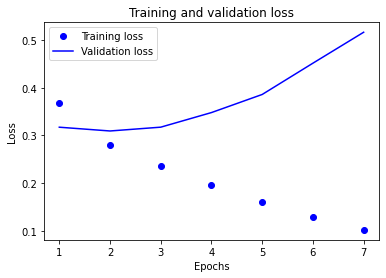

In [23]:
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

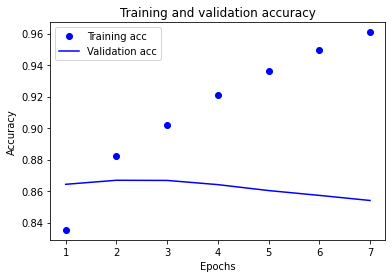

In [24]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding layer

In [25]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [26]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.17127553, -0.4733094 , -0.07626158, -0.37245145, -0.13116367,
       -0.00843991, -0.37373605,  0.23766099,  0.06276471, -0.21232107,
       -0.16553335,  0.2975028 ,  0.17545542,  0.17498845, -0.04006502,
       -0.25294286,  0.09577604,  0.24753495, -0.16777459,  0.00320938,
        0.3461972 ,  0.14610343, -0.04779609, -0.09452866, -0.01666315,
        0.29597747, -0.05977822, -0.16265938,  0.4804364 ,  0.16963167,
       -0.11016951,  0.35767964, -0.1689672 , -0.04007521, -0.3267729 ,
       -0.12323989,  0.01290575, -0.08995771,  0.13564825, -0.26032546,
       -0.04874568, -0.04495889, -0.11505584,  0.01859411,  0.0046567 ,
       -0.08670555, -0.15720712, -0.04156595, -0.06455227,  0.05487248,
        0.01505472,  0.03089325, -0.13294585, -0.16081627, -0.33589652,
       -0.14384319, -0.2509509 , -0.16847579, -0.27082583, -0.03719793,
        0.11961129, -0.39457503,  0.1144471 , -0.13236214,  0.10332991,
        0.00600599, -0.0866747 , -0.14674878,  0.17265153,  0.08

In [28]:
word_vectors.similar_by_word("기쁨")

[('색다르', 0.8788125514984131),
 ('빨려', 0.8681228160858154),
 ('김현주', 0.866858720779419),
 ('핫', 0.8664326667785645),
 ('왜냐하면', 0.8652523756027222),
 ('릴리', 0.8624348640441895),
 ('금성무', 0.8606399297714233),
 ('뜨거운', 0.8575854301452637),
 ('아담스', 0.8537447452545166),
 ('오래간만', 0.8518842458724976)]

# 한국어 Word2Vec

In [29]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/tmp/ipykernel_3345/3546430211.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['컴퓨터']


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [30]:
word2vec.similar_by_word("기쁨")

/tmp/ipykernel_3345/58648567.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("기쁨")


[('즐거움', 0.7912124395370483),
 ('슬픔', 0.7767106294631958),
 ('아름다움', 0.6815950870513916),
 ('웃음', 0.681169331073761),
 ('괴로움', 0.6798388957977295),
 ('행운', 0.6609852313995361),
 ('인생', 0.657120406627655),
 ('젊음', 0.6522527933120728),
 ('영광', 0.6512227058410645),
 ('행복', 0.6493781805038452)]

In [31]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3345/903695008.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3345/903695008.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [32]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [33]:
LSTM_ko.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [34]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [36]:
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 22s 6ms/step - loss: 0.3865 - accuracy: 0.8243 - val_loss: 0.3328 - val_accuracy: 0.8536

Epoch 00001: saving model to best_model_ko.h5
Epoch 2/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.2943 - accuracy: 0.8756 - val_loss: 0.3169 - val_accuracy: 0.8646

Epoch 00002: saving model to best_model_ko.h5
Epoch 3/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.2523 - accuracy: 0.8945 - val_loss: 0.3233 - val_accuracy: 0.8647

Epoch 00003: saving model to best_model_ko.h5
Epoch 4/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.2155 - accuracy: 0.9115 - val_loss: 0.3463 - val_accuracy: 0.8614

Epoch 00004: saving model to best_model_ko.h5
Epoch 5/10
3631/3631 [==============================] - 20s 6ms/step - loss: 0.1806 - accuracy: 0.9276 - val_loss: 0.3719 - val_accuracy: 0.8635

Epoch 00005: saving model to best_model_ko.h5
Epoch 6/10
3631/3631 [==================

In [37]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4724 - accuracy: 0.8530
[0.4724319577217102, 0.8529812693595886]


# Conv1D

# Model

In [38]:
vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [39]:
conv1d_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

# Train

In [40]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.4119 - accuracy: 0.8024 - val_loss: 0.3638 - val_accuracy: 0.8295
Epoch 2/10
3631/3631 [==============================] - 16s 5ms/step - loss: 0.3086 - accuracy: 0.8618 - val_loss: 0.3709 - val_accuracy: 0.8310
Epoch 3/10
3631/3631 [==============================] - 16s 5ms/step - loss: 0.2265 - accuracy: 0.9011 - val_loss: 0.4194 - val_accuracy: 0.8210
Epoch 4/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.1615 - accuracy: 0.9311 - val_loss: 0.5195 - val_accuracy: 0.8155
Epoch 5/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.1222 - accuracy: 0.9470 - val_loss: 0.6139 - val_accuracy: 0.8157
Epoch 6/10
3631/3631 [==============================] - 16s 5ms/step - loss: 0.1007 - accuracy: 0.9548 - val_loss: 0.6835 - val_accuracy: 0.8142
Epoch 7/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.0847 - accuracy: 0.9611 - val_loss: 0.8174 - val_ac

In [42]:
results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.1232 - accuracy: 0.8036
[1.1232441663742065, 0.8035885095596313]


# Visualization

In [43]:
conv1d_history_dict = conv1d_history.history

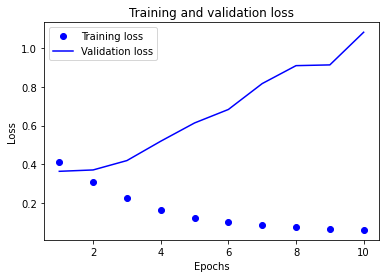

In [44]:
acc = conv1d_history_dict['accuracy']
val_acc = conv1d_history_dict['val_accuracy']
loss = conv1d_history_dict['loss']
val_loss = conv1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

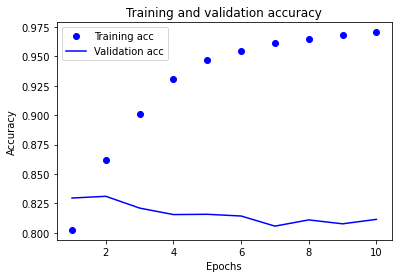

In [45]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding layer

In [46]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [47]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [48]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.22425005,  0.08563868,  0.22698757, -0.22024444, -0.1630898 ,
       -0.12745345,  0.01895474, -0.1321246 ,  0.24100554,  0.06928411,
       -0.10496495, -0.09752375,  0.08494485,  0.08214408, -0.12137713,
        0.0740371 ,  0.1692131 ,  0.25690758,  0.11873821,  0.04744293,
       -0.04817246,  0.05678261, -0.2008994 , -0.12783693,  0.06421159,
        0.20650378,  0.0979268 ,  0.32215217, -0.23000053,  0.01074777,
        0.17977618,  0.07158726,  0.17182799,  0.14063674, -0.08232594,
        0.03003947, -0.0305318 , -0.0212414 ,  0.3515167 ,  0.29034314,
        0.30066037,  0.2529784 , -0.0450513 ,  0.12394278,  0.17177269,
       -0.27412638, -0.07325122,  0.09690156,  0.18376365, -0.08972169,
       -0.23204058,  0.12546708,  0.29726213,  0.197015  , -0.1763342 ,
       -0.02091515, -0.27895808, -0.22910805,  0.09073639,  0.27260056,
        0.2038593 , -0.02866236, -0.07550489, -0.26291078], dtype=float32)

In [49]:
word_vectors.similar_by_word("기쁨")

[('김민희', 0.7210241556167603),
 ('젬', 0.7171822786331177),
 ('훈', 0.7168929576873779),
 ('학도', 0.7027633190155029),
 ('펑펑', 0.6898741722106934),
 ('감춰진', 0.685901403427124),
 ('알모도바르', 0.6845656633377075),
 ('엇갈리', 0.68216872215271),
 ('유코', 0.6814687848091125),
 ('배출', 0.6794769763946533)]

# 한국어 Word2Vec

In [50]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/tmp/ipykernel_3345/3546430211.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['컴퓨터']


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [51]:
word2vec.similar_by_word("기쁨")

/tmp/ipykernel_3345/58648567.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("기쁨")


[('즐거움', 0.7912124395370483),
 ('슬픔', 0.7767106294631958),
 ('아름다움', 0.6815950870513916),
 ('웃음', 0.681169331073761),
 ('괴로움', 0.6798388957977295),
 ('행운', 0.6609852313995361),
 ('인생', 0.657120406627655),
 ('젊음', 0.6522527933120728),
 ('영광', 0.6512227058410645),
 ('행복', 0.6493781805038452)]

In [52]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3345/903695008.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3345/903695008.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [53]:
vocab_size = 10000
word_vector_dim = 200

conv1d_model_ko = keras.Sequential()
conv1d_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.MaxPooling1D(5))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_model_ko.add(keras.layers.Dense(128, activation='relu'))
conv1d_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [54]:
conv1d_model_ko.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 64)            89664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [55]:
conv1d_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [56]:
history = conv1d_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 19s 5ms/step - loss: 0.4680 - accuracy: 0.7697 - val_loss: 0.4021 - val_accuracy: 0.8107
Epoch 2/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.3599 - accuracy: 0.8368 - val_loss: 0.3779 - val_accuracy: 0.8244
Epoch 3/10
3631/3631 [==============================] - 19s 5ms/step - loss: 0.3124 - accuracy: 0.8615 - val_loss: 0.3835 - val_accuracy: 0.8207
Epoch 4/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.2669 - accuracy: 0.8839 - val_loss: 0.4043 - val_accuracy: 0.8245
Epoch 5/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.2206 - accuracy: 0.9053 - val_loss: 0.4754 - val_accuracy: 0.8156
Epoch 6/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1815 - accuracy: 0.9222 - val_loss: 0.5067 - val_accuracy: 0.8159
Epoch 7/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1517 - accuracy: 0.9352 - val_loss: 0.6055 - val_ac

In [57]:
results = conv1d_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7452 - accuracy: 0.8073
[0.745166003704071, 0.8073112964630127]


# GlobalMaxPooling

# Model

In [58]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [59]:
GMP_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


# Train

In [60]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [61]:
GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.3963 - accuracy: 0.8191 - val_loss: 0.3427 - val_accuracy: 0.8497
Epoch 2/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.3053 - accuracy: 0.8721 - val_loss: 0.3410 - val_accuracy: 0.8537
Epoch 3/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.2642 - accuracy: 0.8918 - val_loss: 0.3494 - val_accuracy: 0.8549
Epoch 4/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.2284 - accuracy: 0.9093 - val_loss: 0.3728 - val_accuracy: 0.8512
Epoch 5/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.1963 - accuracy: 0.9247 - val_loss: 0.4017 - val_accuracy: 0.8512
Epoch 6/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.1668 - accuracy: 0.9374 - val_loss: 0.4457 - val_accuracy: 0.8447
Epoch 7/10
3631/3631 [==============================] - 11s 3ms/step - loss: 0.1404 - accuracy: 0.9481 - val_loss: 0.4910 - val_ac

In [62]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6616 - accuracy: 0.8278
[0.6615723967552185, 0.827837347984314]


# Visualization

In [63]:
GMP_history_dict = GMP_history.history

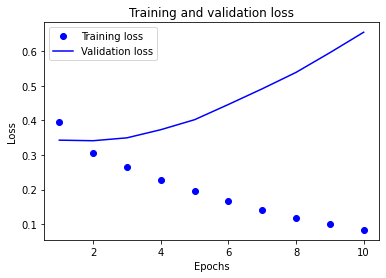

In [64]:
acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

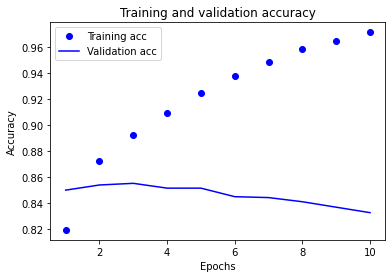

In [65]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding layer

In [66]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [67]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [68]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.11415856, -0.13802548, -0.2585948 , -0.20648168, -0.04367525,
       -0.02396252, -0.1437793 , -0.00209867,  0.04035386, -0.02493482,
       -0.04127597,  0.07963619, -0.08542237, -0.25044543, -0.09343093,
       -0.41656896,  0.00247509, -0.07288197, -0.39603817, -0.10022172,
        0.23628277,  0.02850838,  0.09382757, -0.08735151, -0.34194818,
       -0.06110068, -0.05996435, -0.06634905, -0.02265411, -0.06305923,
       -0.16622037,  0.20962468, -0.22440886, -0.10523154, -0.05180118,
        0.01837965, -0.05211669, -0.01964114, -0.2176474 , -0.04941903,
        0.06392356, -0.16296785,  0.0358411 , -0.10784081,  0.13902672,
        0.13560635, -0.04269624, -0.37761933, -0.04663725,  0.06988158,
       -0.6283348 , -0.04889837, -0.11322063, -0.04268038, -0.18857244,
       -0.14210744, -0.26388854, -0.04676099, -0.0510636 , -0.18125929,
       -0.09987528, -0.01436347,  0.03979059, -0.04925288], dtype=float32)

In [69]:
word_vectors.similar_by_word("기쁨")

[('더라고요', 0.6942203640937805),
 ('재방송', 0.6929516196250916),
 ('드럼', 0.6818866729736328),
 ('쪼', 0.6726386547088623),
 ('애잔', 0.6713457107543945),
 ('하나님', 0.66595458984375),
 ('김래원', 0.6658368706703186),
 ('끝내준다', 0.6651912927627563),
 ('+_+', 0.6590120196342468),
 ('여운', 0.656425416469574)]

# 한국어 Word2Vec

In [70]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/tmp/ipykernel_3345/3546430211.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['컴퓨터']


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [71]:
word2vec.similar_by_word("기쁨")

/tmp/ipykernel_3345/58648567.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("기쁨")


[('즐거움', 0.7912124395370483),
 ('슬픔', 0.7767106294631958),
 ('아름다움', 0.6815950870513916),
 ('웃음', 0.681169331073761),
 ('괴로움', 0.6798388957977295),
 ('행운', 0.6609852313995361),
 ('인생', 0.657120406627655),
 ('젊음', 0.6522527933120728),
 ('영광', 0.6512227058410645),
 ('행복', 0.6493781805038452)]

In [72]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3345/903695008.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3345/903695008.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [73]:
vocab_size = 10000
word_vector_dim = 200

GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [74]:
GMP_model_ko.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [75]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.5350 - accuracy: 0.7225 - val_loss: 0.4459 - val_accuracy: 0.7891
Epoch 2/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.4137 - accuracy: 0.8105 - val_loss: 0.4029 - val_accuracy: 0.8169
Epoch 3/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.3647 - accuracy: 0.8389 - val_loss: 0.3868 - val_accuracy: 0.8258
Epoch 4/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.3299 - accuracy: 0.8579 - val_loss: 0.3895 - val_accuracy: 0.8255
Epoch 5/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.3017 - accuracy: 0.8726 - val_loss: 0.3765 - val_accuracy: 0.8349
Epoch 6/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.2765 - accuracy: 0.8855 - val_loss: 0.3814 - val_accuracy: 0.8361
Epoch 7/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.2527 - accuracy: 0.8980 - val_loss: 0.3978 - val_ac

In [77]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4352 - accuracy: 0.8302
[0.4352416396141052, 0.8301767706871033]


# [E-06] 회고


여태까지 했던 exploration 중에서 제일 힘들었던 같습니다.😂 늘 초반에는 자신감있게 시작해서 기·승 부분 까지는 평화롭고 행복하고 즐거운데 '전' 시작부분을 넘어서 '결'로 가는 과정이 늘 눈물이 나게하네요😭

자신있게 데이터 불러오고 데이터로더 구성까지는 즐거웠는데, 모델 구성을 위한 데이터 분석 및 가공에서ㅎㅎ 패딩부터 조금씩 막히기 시작했습니다.

그래서 이번에도 https://github.com/JaeHeee/AIFFEL_Project/tree/master/EXPLORATION 이분의 깃허브를 참고했습니다😊🤗😅

일단 코드를 복사해서 패딩 문제를 해결했는데요, 오답을 해야 어떻게 해결이 되었는지 알 수 있을 것 같습니다😂 (오답 필수🤗🤗🤗)

그리고 이번 exploration을 진행하면서, 한국어Work2Vec을 이행하는 과정에서 LSM에 있는 링크에 들어갔는데, 어떻게 실행해야하는지 감이 안 잡혀서 고전을 했습니다.

그래도 구글링으로 어떻게 어떻게 찾아보고, 설치를 하는데 여기서도 오류가 발생해서 다시 구글링을 하고, 또 어떻게 어떻게 클라우드 쉘에 들어가서 gensim을 설치했는데, 오류가 떴습니다ㅎㅎ

당연히 버전으로 인한 오류였는데요, 어떻게 다운그레이드를 하나 찾아보다가 수완님께 여쭤보고 방법을 찾았는데, 제 노트북이 문제인지 계속 오류가 반복 되었습니다.

다시 서치해서 방법을 찾아보니 unistall로 gensim을 삭제했다가 conda라는 방법을 사용해보기도 했는데, 오류가 계속 떴습니다. 리스타트의 문제인가 싶어서 리스타트를 해도 계속 오류가 떠서 어떻게 해야하나 고민을 하고 있었는데, 준서님이 구세주처럼 나타나셔서 방법을 알려주고 가셨습니다.

주피터노트에 바로 실행하는 방법이었는데요, 알려주신대로 실행해보니 오류 없이 다음 코드로 넘어가서 감동이었습니다.😆😆 그리고 또 제가 생각이 막혀있었다는 걸 상기시켜주었어요. 클라우드 쉘이 안 된다면 주피터 노트에서 한 번 실행해볼 수도 있는데, 전혀 생각을 못했더라고요. 응용을 이렇게 못 해서야... 진짜 많은 예제들을 풀고 오답을 하는 것이 답이라는 것을 느꼈습니다.

그리고 순조롭게 위의 깃허브를 참고해 3가지 모델을 사용해 exploration 6번을 진행했습니다.

LSTM, Conv1D, GlobalMaxPooling 이렇게 3가지의 모델을 사용하셔서 저도 일단 급한대로 따라했는데, 이것도 선 실행 후 학습의 경로로 이번 설연휴때 휘몰아치는 복습에 끼어넣어서 공부할 예정입니다.

이번 exploration 6번은 한국어Work2Vec 임베딩 기능을 활용하는데 어려움이 있었고... 그냥 전부다 어려웠습니다😂😂

네, 그래서 그냥 꾸준히 해이해지지않고 공부를 지속할 수 있도록 노력하겠습니다.🔥🔥🔥